In [2]:
import random, os, math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

Throughput for trial-1 per Clients Number:
- {1: '287.83', 10: '3103.88', 100: '30759.69', 1000: '51131.74', 10000: '36851.68', 1000000: '64603.32'}
Throughput for trial-2 per Clients Number:
- {1: '290.38', 10: '2993.52', 100: '29861.07', 1000: '57736.25', 10000: '44036.02', 100000: '42874.67', 1000000: '63485.33'}
Throughput for trial-9 per Clients Number:
- {1: '2565.08', 10: '17579.41', 100: '29452.78', 1000: '17539.54', 10000: '7697.81', 100000: '3184.21'}


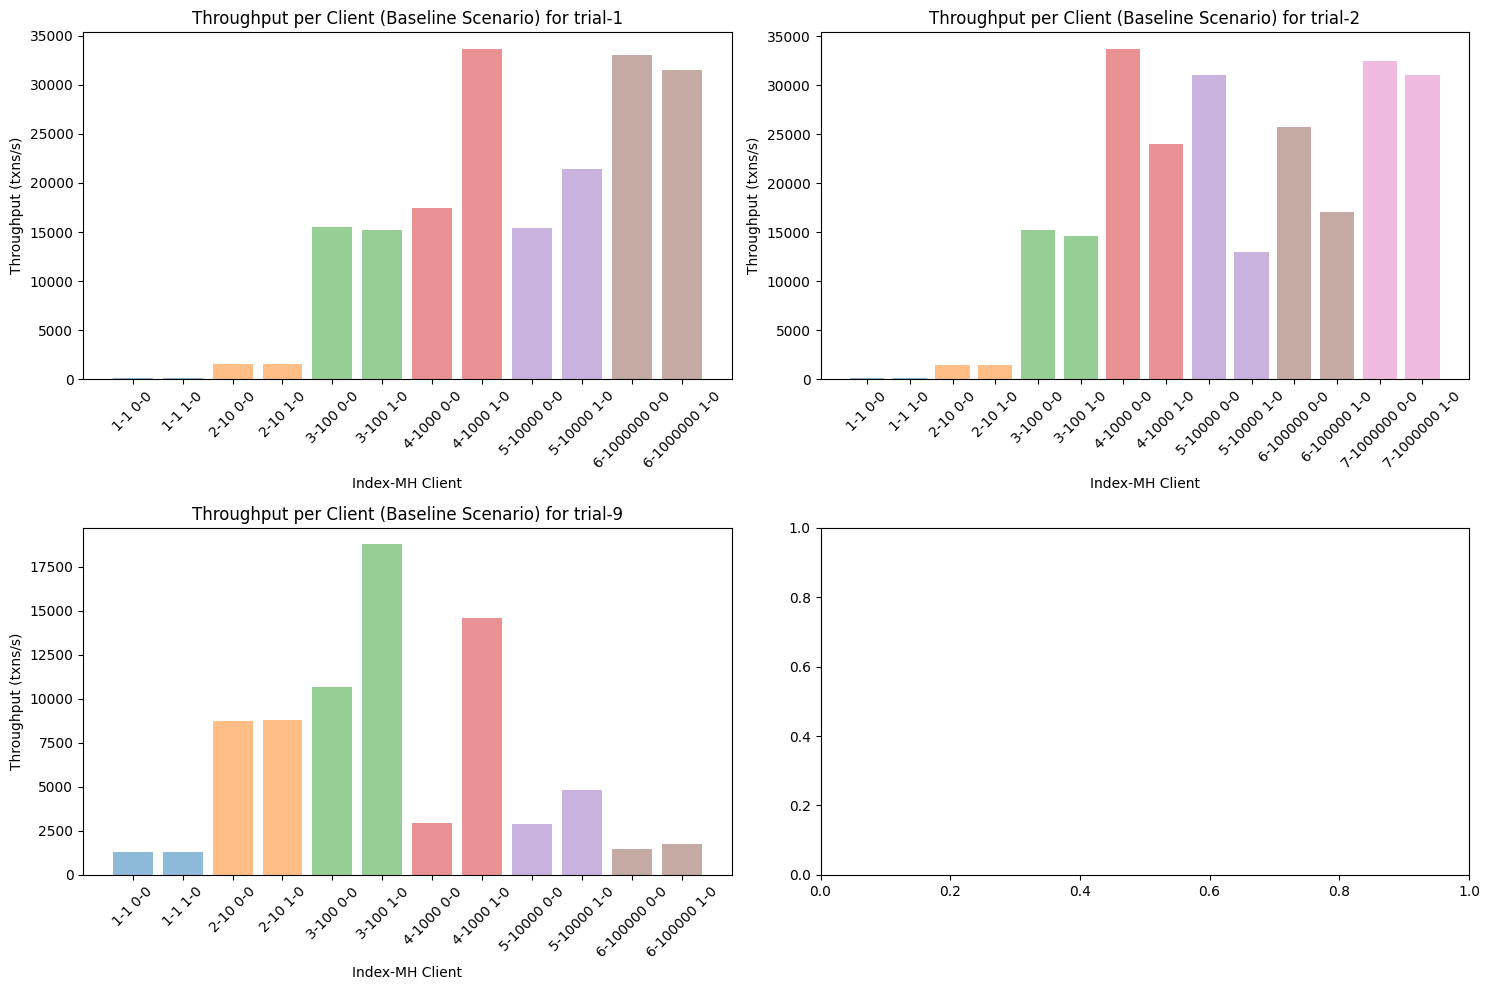

In [4]:
# Baseline Scenario Throughput Analysis

# Variables that need to be set
trial_tags = ["trial-1", "trial-2", "trial-9"]
cols = 2
rows = int(np.ceil(len(trial_tags) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

for i, trial_tag in enumerate(trial_tags):
    # Collect throughput data
    clients_nums = defaultdict(dict)
    base_dir = f"../../data/pps/scalability/{trial_tag}/Detock"
    for experiment in os.listdir(base_dir):
        clients_num = int(experiment.split("-")[-1])
        index = int(experiment.split("-")[0])
        current = {}
        for client in os.listdir(f"{base_dir}/{experiment}/client"):
            if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
                summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

                duration = metadata["duration"].sum()
                throughput = summary["committed"].sum() / duration
                current[client] = throughput
        clients_nums[clients_num][index] = current

    # Plot the throughput for each experiment per client
    for clients_num in sorted(clients_nums.keys()):
        for index in sorted(clients_nums[clients_num].keys()):
            current = clients_nums[clients_num][index]
            axes[i].bar([f"{index}-{clients_num} {client}" for client in current.keys()], current.values(), alpha=0.5)
    axes[i].set_title(f"Throughput per Client (Baseline Scenario) for {trial_tag}")
    axes[i].set_xlabel("Index-MH Client")
    axes[i].set_ylabel("Throughput (txns/s)")
    axes[i].tick_params(axis='x', rotation=45)

    # Print the total average throughput for each number of clients
    print(f"Throughput for {trial_tag} per Clients Number:")
    throughput = {}
    for clients_num in sorted(clients_nums.keys()):
        total = 0
        for index in sorted(clients_nums[clients_num].keys()):
            current = clients_nums[clients_num][index]
            total += sum(current.values())
        throughput[clients_num] = total / len(clients_nums[clients_num])
    print("-", {clients_num: f"{v:.2f}" for clients_num, v in throughput.items()})
plt.tight_layout()
plt.show()

Throughput for trial-2 per Clients Number:


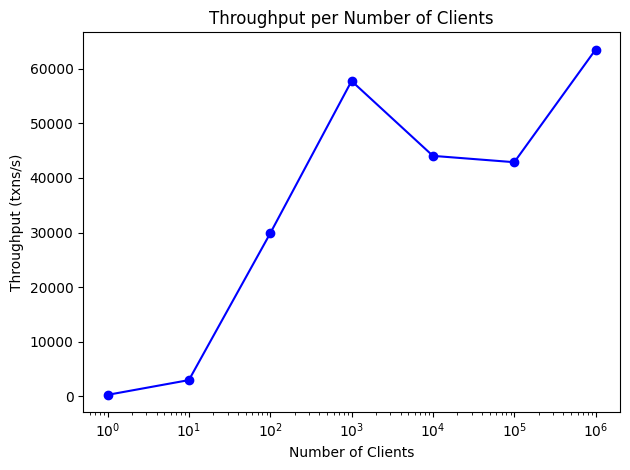

In [15]:
# Baseline Scenario Throughput Analysis

# Variables that need to be set
trial_tag = "trial-2"

# Collect throughput data
throughput = defaultdict(int)
base_dir = f"../../data/pps/scalability/{trial_tag}/Detock"
for experiment in os.listdir(base_dir):
    clients_num = int(experiment.split("-")[-1])
    index = int(experiment.split("-")[0])
    current = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
            summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

            duration = metadata["duration"].sum()
            throughput[clients_num] += summary["committed"].sum() / duration
            current[client] = throughput
print(f"Throughput for {trial_tag} per Clients Number:")
throughput = sorted(throughput.items())

plt.plot(
    [clients_num for clients_num, _ in throughput],
    [v for _, v in throughput],
    marker="o",
    linestyle="-",
    color="blue",
)
plt.title(f"Throughput per Number of Clients")
plt.xlabel("Number of Clients")
plt.ylabel("Throughput (txns/s)")
plt.xscale("log")
plt.tight_layout()
plt.show()

In [15]:
# Baseline Scenario Involved Regions and Partitions Analysis

# Variables that need to be set
trial_tags = ["trial-1", "trial-5", "trial-mp_0-1"]
samples = 10000

for i, trial_tag in enumerate(trial_tags):
    # Collecting involved regions and partitions data
    print(f"Processing {trial_tag}...")
    base_dir = f"../../data/pps/baseline/{trial_tag}/Detock"
    involved_regions = defaultdict(dict)
    involved_partitions = defaultdict(dict)
    for experiment in os.listdir(base_dir):
        mh = int(experiment.split("-")[-1])
        index = int(experiment.split("-")[0])
        involved_regions[mh][index] = {}
        involved_partitions[mh][index] = {}
        for client in os.listdir(f"{base_dir}/{experiment}/client"):
            if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
                involved_regions[mh][index][client] = dict(Counter([x for x in transactions["regions"][:samples].values \
                                                 if not isinstance(x, float) or not math.isnan(x)]))
                involved_partitions[mh][index][client] = dict(Counter([x for x in transactions["partitions"][:samples].values \
                                                    if not isinstance(x, float) or not math.isnan(x)]))
    
    # Print the involved regions and partitions for each mh
    for mh in sorted(involved_regions.keys()):
        print(f"- Results for MH {mh}")
        for index in sorted(involved_regions[mh].keys()):
            current = involved_regions[mh][index]
            print(f"-- {index} Reg:", 
                  {client: {regions: f"{current[client][regions]} ({int(current[client][regions] / sum(current[client].values()) * 100)}%)" \
                    for regions in sorted(current[client])} for client in current})
            current = involved_partitions[mh][index]
            print(f"--- Partitions:", 
                  {client: {partitions: f"{current[client][partitions]} ({int(current[client][partitions] / sum(current[client].values()) * 100)}%)" \
                    for partitions in current[client]} for client in current})

Processing trial-1...
- Results for MH 0
-- 1 Reg: {'0-0': {0.0: '9455 (95%)', 1.0: '450 (4%)'}, '1-0': {0.0: '438 (4%)', 1.0: '9466 (95%)'}}
--- Partitions: {'0-0': {'1': '4167 (42%)', '0': '4266 (43%)', '0;1': '749 (7%)', '1;0': '723 (7%)'}, '1-0': {'1': '4321 (43%)', '0;1': '694 (7%)', '0': '4080 (41%)', '1;0': '809 (8%)'}}
-- 2 Reg: {'0-0': {0.0: '9458 (95%)', 1.0: '423 (4%)'}, '1-0': {0.0: '429 (4%)', 1.0: '9456 (95%)'}}
--- Partitions: {'0-0': {'0;1': '925 (9%)', '0': '4170 (42%)', '1': '4225 (42%)', '1;0': '561 (5%)'}, '1-0': {'1': '4225 (42%)', '0': '4158 (42%)', '1;0': '889 (8%)', '0;1': '613 (6%)'}}
- Results for MH 20
-- 3 Reg: {'0-0': {'0': '8330 (83%)', '0;1': '613 (6%)', '1': '1017 (10%)'}, '1-0': {'0': '1001 (10%)', '0;1': '564 (5%)', '1': '8330 (84%)'}}
--- Partitions: {'0-0': {'0': '4156 (41%)', '1': '4234 (42%)', '0;1': '924 (9%)', '1;0': '646 (6%)'}, '1-0': {'0': '4275 (43%)', '1': '4180 (42%)', '1;0': '769 (7%)', '0;1': '671 (6%)'}}
-- 4 Reg: {'0-0': {'0': '8288 (83

In [9]:
# Baseline Scenario Record Access Analysis

# Variables that need to be set
trial_tag = "trial-5"
samples = 10000

base_dir = f"../../data/pps/baseline/{trial_tag}/Detock"
experiments = os.listdir(base_dir)
experiments = sorted(experiments, key=lambda x: int(x.split("-")[-1]))

record_access = {}
for i, experiment in enumerate(experiments):
    print(f"Processing {experiment}...")
    # Collecting transaction codes
    codes = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
            codes[client] = transactions["code"].tolist()[:samples]

    # Collecting product access data for get_parts_by_product
    gpbp_type = {}
    for client in codes.keys():
        gpbp_type[client] = []
        for code in codes[client]:
            type = code.split(";")[0]
            if type == "get_parts_by_product":
                gpbp_type[client].append(int(code.split(";")[1]))
    record_access[experiment] = gpbp_type

Processing 1-0...
Processing 2-0...
Processing 3-20...
Processing 4-20...
Processing 6-40...
Processing 5-40...
Processing 8-60...
Processing 7-60...
Processing 10-80...
Processing 9-80...
Processing 12-100...
Processing 11-100...


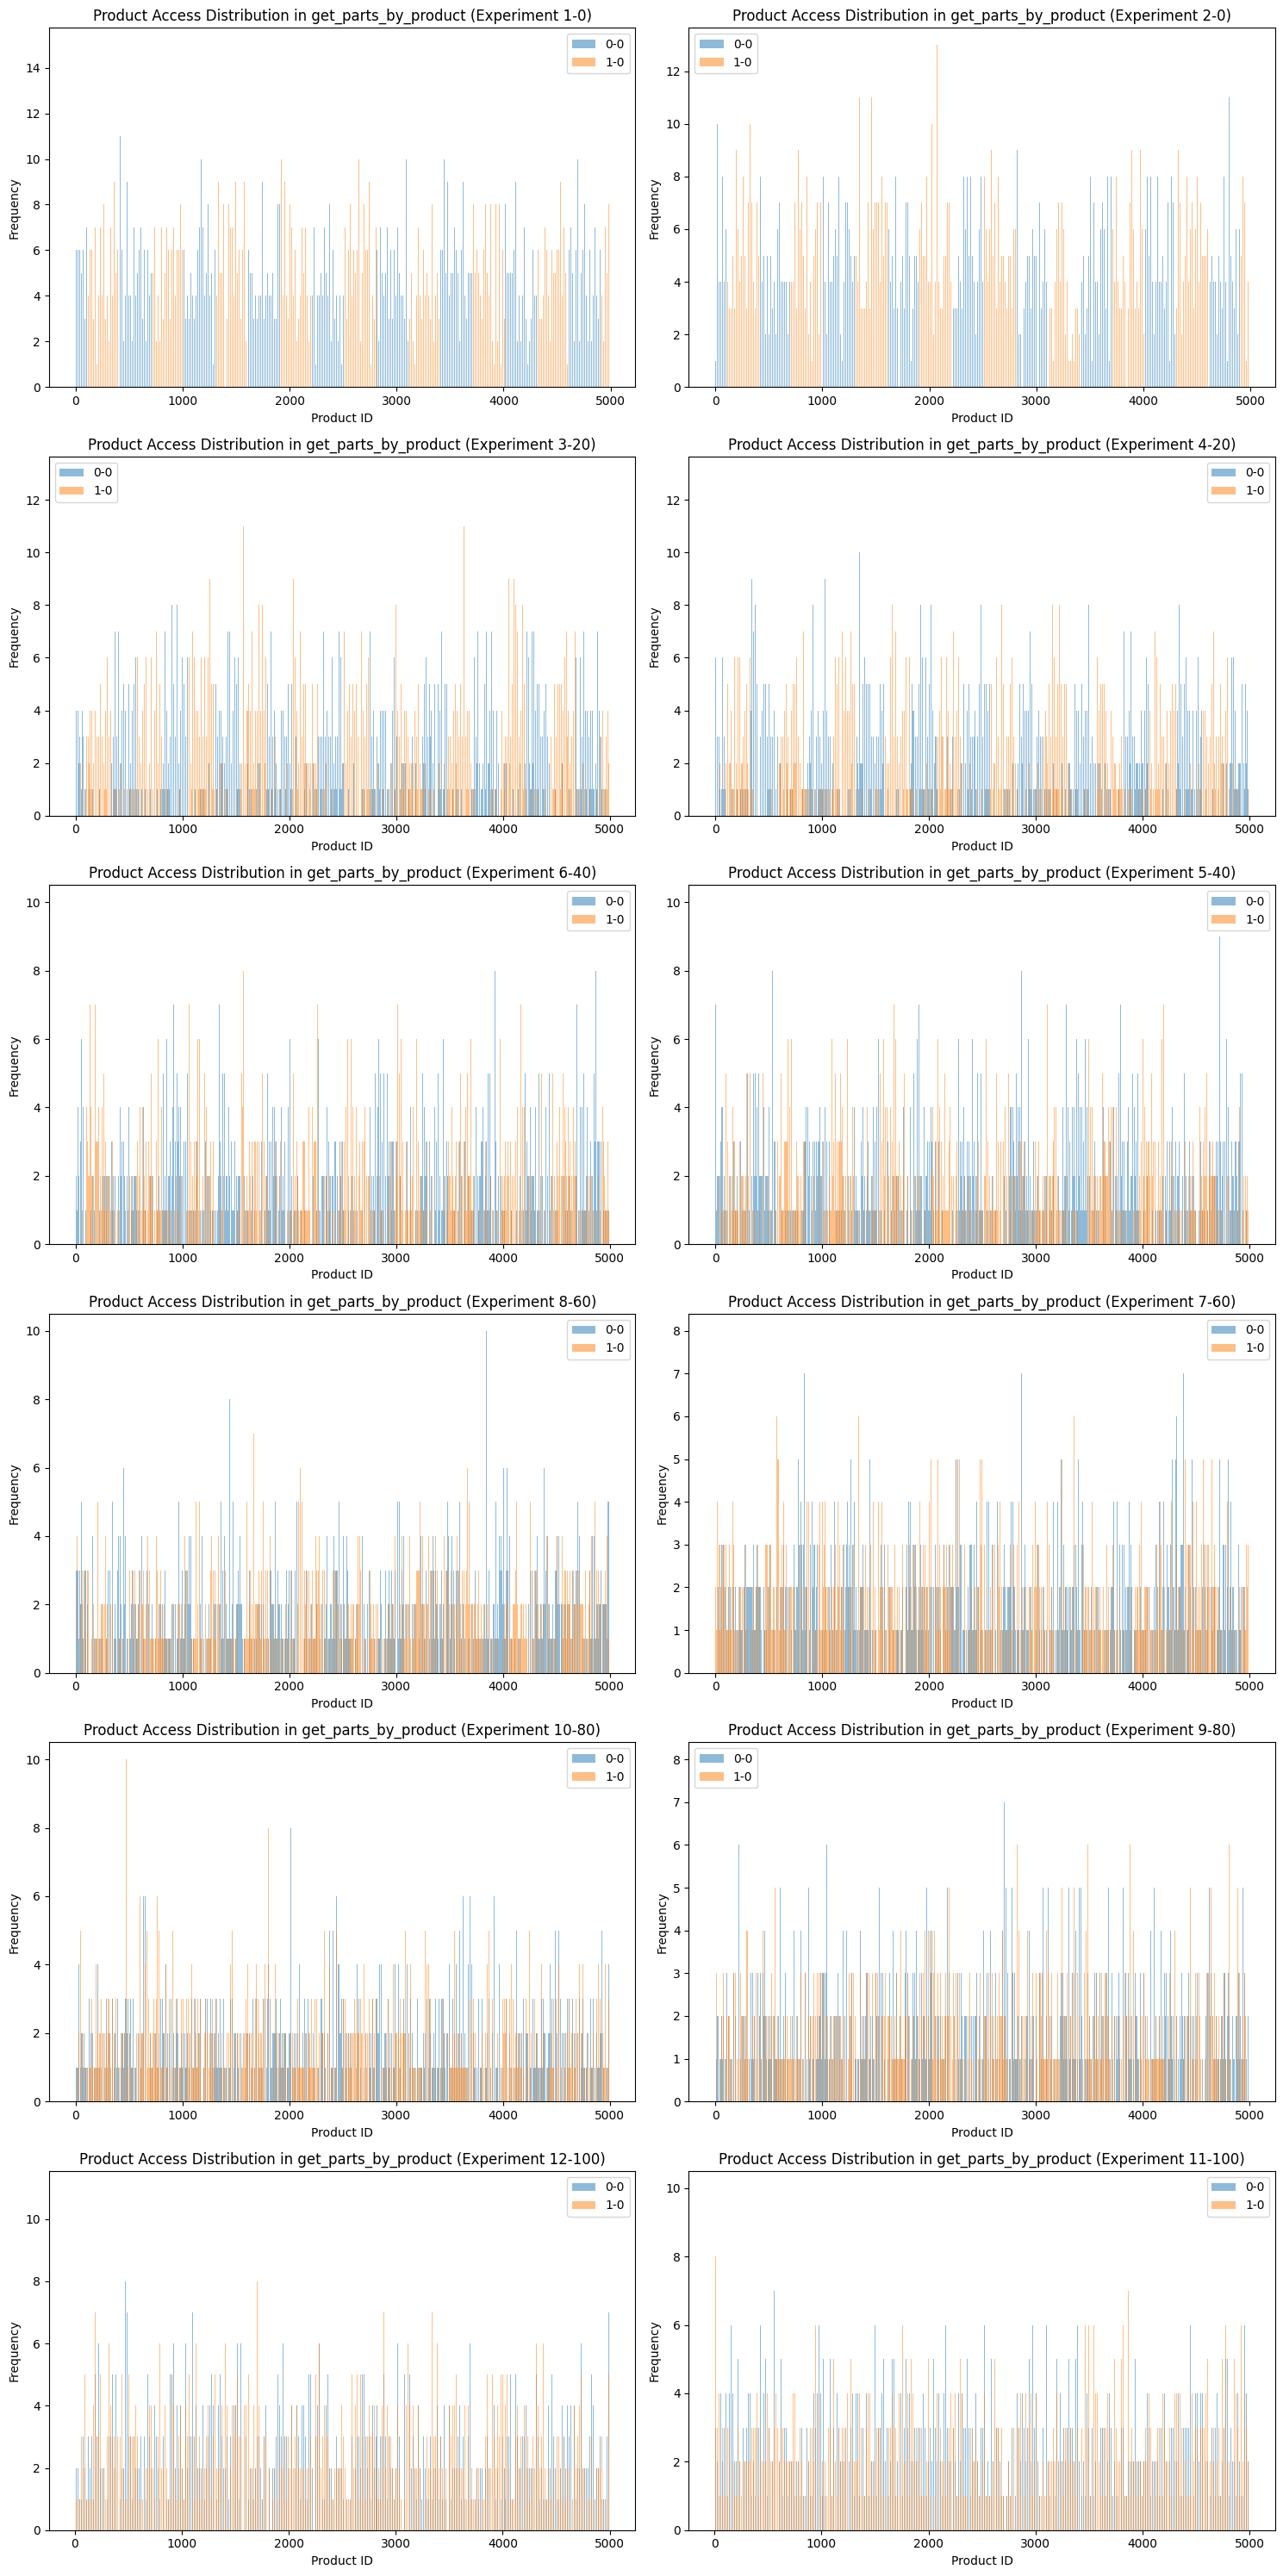

In [10]:
# Variables that need to be set
cols = 2

rows = int(np.ceil(len(experiments) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

# Plot the product access distribution for each experiment for get_parts_by_product
for i, experiment in enumerate(experiments):
    gpbp_type = record_access[experiment]
    for j, client in enumerate(gpbp_type.keys()):
        mn = min(gpbp_type[client])
        mx = max(gpbp_type[client])
        axes[i].hist(gpbp_type[client], bins=range(mn, mx + 1), alpha=0.5, label=client)
    axes[i].set_title(f"Product Access Distribution in get_parts_by_product (Experiment {experiment})")
    axes[i].set_xlabel("Product ID")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [12]:
print(len(set(record_access["12-100"]["0-0"]).intersection(set(record_access["12-100"]["1-0"]))))

2066
